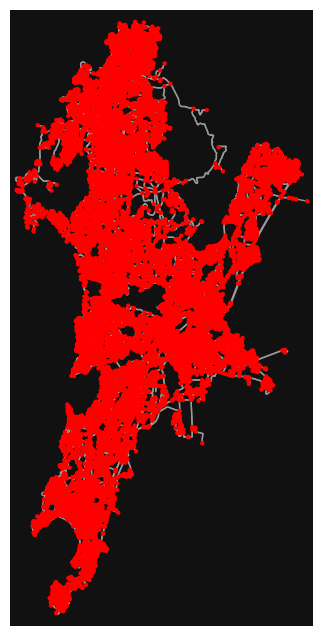

In [2]:
# Smart Waste Collection & Routing - Data Simulation Notebook
# ==========================================================

# 2.1 Collect and Explore Open Datasets (OSM)
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

# Fetch road network for demo city: Bikhroli, Mumbai
place = "Mumbai, India"
G = ox.graph_from_place(place, network_type="drive")

# Convert to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Plot the road network
fig, ax = ox.plot_graph(G, node_size=10, node_color="red")


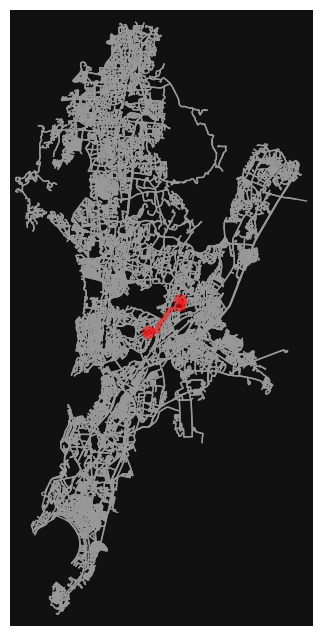

In [4]:
import osmnx as ox

place = "Mumbai, India"
G = ox.graph_from_place(place, network_type="drive")

# Example bins and depot coordinates
bin_lat, bin_lon = 19.07, 72.87  
depot_lat, depot_lon = 19.089753,72.8906098

# Find nearest nodes
bin_node = ox.distance.nearest_nodes(G, bin_lon, bin_lat)
depot_node = ox.distance.nearest_nodes(G, depot_lon, depot_lat)

# Compute shortest path
route = ox.shortest_path(G, depot_node, bin_node, weight='length')

# Plot route
fig, ax = ox.plot_graph_route(G, route, route_color='r', route_linewidth=4, node_size=0)


In [ ]:

# ----------------------------
# CONFIG
# ----------------------------
CITY_NAME = "Vikroli, Mumbai, India"
NUM_BINS = 30
OUTPUT_DIR = "sim_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:

# ----------------------------
# 1. Fetch Road Network
# ----------------------------
print(f"Fetching road network for {CITY_NAME}...")
G = ox.graph_from_place(CITY_NAME, network_type="drive")
nodes, edges = ox.graph_to_gdfs(G)

# ----------------------------
# 2. Generate Bin Locations
# ----------------------------
print(f"Generating {NUM_BINS} simulated bin locations...")
bin_locations = nodes.sample(NUM_BINS).copy()
bin_locations["bin_id"] = [f"BIN_{i+1}" for i in range(len(bin_locations))]

# Save as GeoJSON
bin_locations[["bin_id", "x", "y"]].to_file(
    os.path.join(OUTPUT_DIR, "bin_locations.geojson"), driver="GeoJSON"
)

# ----------------------------
# 3. Simulate Bin Fill Levels
# ----------------------------
print("Simulating bin fill levels over 7 days (hourly)...")
timestamps = pd.date_range(start="2025-09-01", periods=24 * 7, freq="H")

records = []
for ts in timestamps:
    for _, row in bin_locations.iterrows():
        # Fill grows during day, slower at night
        base = (ts.hour * 4) % 100
        fill = min(100, np.random.normal(loc=base, scale=15))
        records.append([ts, row["bin_id"], max(0, round(fill, 2))])

bin_fill_df = pd.DataFrame(records, columns=["timestamp", "bin_id", "fill_level"])
bin_fill_df.to_csv(os.path.join(OUTPUT_DIR, "bin_fill.csv"), index=False)

# ----------------------------
# 4. Simulate Traffic Patterns
# ----------------------------
print("Simulating traffic patterns...")
traffic = {
    str(hour): round(
        (0.8 if 8 <= hour <= 11 or 17 <= hour <= 20 else 0.3)
        + np.random.uniform(0, 0.2),
        2,
    )
    for hour in range(24)
}

with open(os.path.join(OUTPUT_DIR, "traffic.json"), "w") as f:
    json.dump(traffic, f, indent=2)

# ----------------------------
# 5. Define Vehicles and Shifts
# ----------------------------
print("Defining static vehicle and shift data...")
vehicles = [
    {"id": "TRUCK_1", "capacity": 1000, "speed": 40},
    {"id": "TRUCK_2", "capacity": 800, "speed": 35},
]
with open(os.path.join(OUTPUT_DIR, "vehicles.json"),
